## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import math
import os
from keras.regularizers import l2
import keras
from math import ceil
import cv2
import time
import matplotlib
from sklearn.metrics import classification_report
import pickle
from keras.models import Model
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop   ,SGD
from keras.layers import BatchNormalization
from tensorflow import set_random_seed
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


> ## Setting the parameter values.

In [2]:
#Training image directorys.
APTOS15_KAGGLE_DIR = '/kaggle/input/resized-2015-2019-blindness-detection-images/resized train 15/'
APTOS19_KAGGLE_DIR = '/kaggle/input/resized-2015-2019-blindness-detection-images/resized train 19/'
APTOS19_KAGGLE_DIR_TEST = '/kaggle/input/aptos2019-blindness-detection/test_images/'

# Training Image csv files.
TRAIN15_DF_PATH = "/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv"
TRAIN19_DF_PATH = '/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv'
TEST19_DF_PATH = '/kaggle/input/aptos2019-blindness-detection/test.csv'

# Specify title of our final model
SAVED_MODEL_NAME = '../working/Resnet50_model.h5'
CSV_logs = "../working/training_log.csv"

# Set seed for reproducability
SEED = 1234
np.random.seed(SEED)
tf.set_random_seed(SEED)

# Parameter defined for image processing and training.
CHANNEL_SIZE = 3 #Size of channel
NUM_EPOCHS15 = 3 #No of epochs for training 2015 Dataset
NUM_EPOCHS19 = 50 #No of epochs for training 2019 Dataset
BATCH_SIZE = 16 # Batach size for training images.
IMG_DIM = 300 # Image size
NUM_CLASSES =5 # No of classes  

CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"} # Defination of each class of images.

### Data Loading.

In [3]:
print("Image IDs and Labels (TRAIN-2019)")       # Loading 2019 blindness-detection TRAIN dataframe
df_train19 = pd.read_csv(TRAIN19_DF_PATH)
print(f"Training images: {df_train19.shape[0]}")
display(df_train19.head())

print("Image IDs and Labels (TRAIN-2015)")
df_train15 = pd.read_csv(TRAIN15_DF_PATH)          # Loading 2015 blindness-detection TRAIN dataframe 
df_train15.rename(columns={'image':'id_code',     # Replacing Coloumn name with the same name present in 2019 dataframe.
                          'level':'diagnosis'}, 
                 inplace=True)
print(f"Training images: {df_train15.shape[0]}")
display(df_train15.head())

print("Image IDs and Labels (TEST")                 # Loading 2019 blindness-detection TEST dataframe
df_test = pd.read_csv(TEST19_DF_PATH)
print(f"Test images: {df_test.shape[0]}")
display(df_test.head())

Image IDs and Labels (TRAIN-2019)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


Image IDs and Labels (TRAIN-2015)
Training images: 35126


,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


Image IDs and Labels (TEST
Test images: 1928


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


## Visualizing the Data

Visualizing the numbers of images present under each class using histograms and ie charts

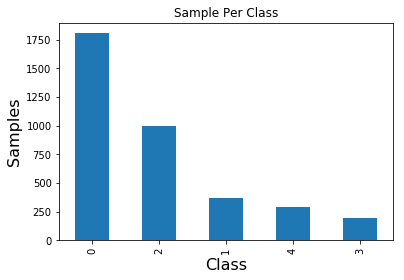

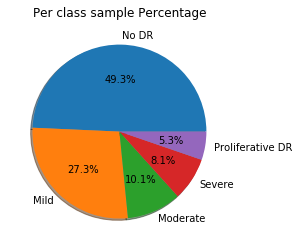

In [4]:
chat_data = df_train19.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
#fig.suptitle('test title', fontsize=20)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Samples', fontsize=16)
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

Visualizing sample images present in each class.

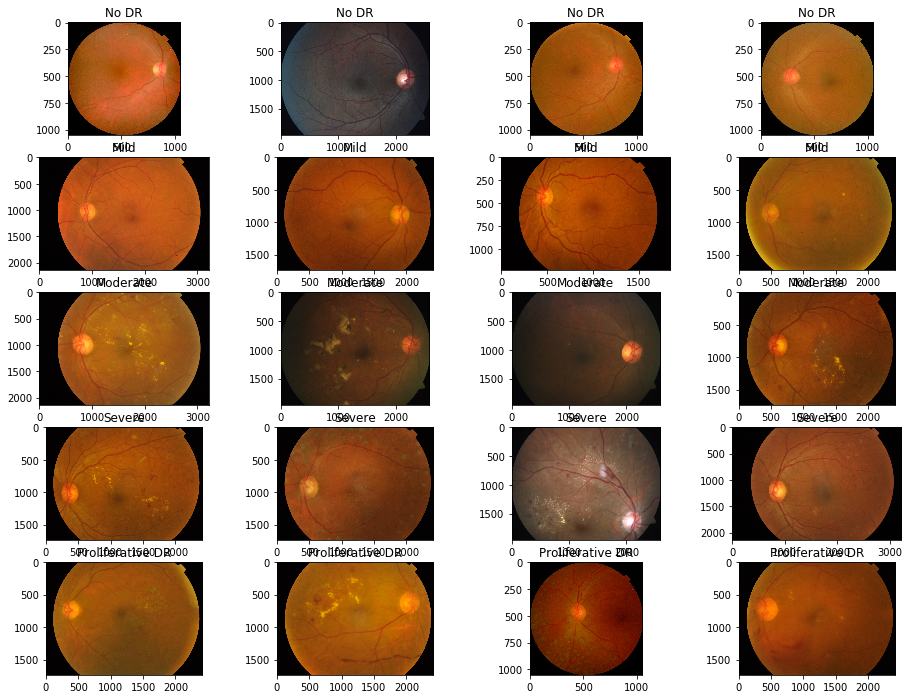

In [5]:
figure=plt.figure(figsize=(20,12))
for target_class in (df_train19['diagnosis'].unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train19.loc[df_train19.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/kaggle/input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])

## Data Preprocessing

* Defining crop_image_from_gray() function to crop out the black border which are not useful for training as they are not providing any feature importance adn focous on the retina image only.

* Defining circle_crop() function to create a circular crop around image center.

In [6]:

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders and Focous on the retina image only.
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

Visualizing sample images present in each class after Preprocessing.

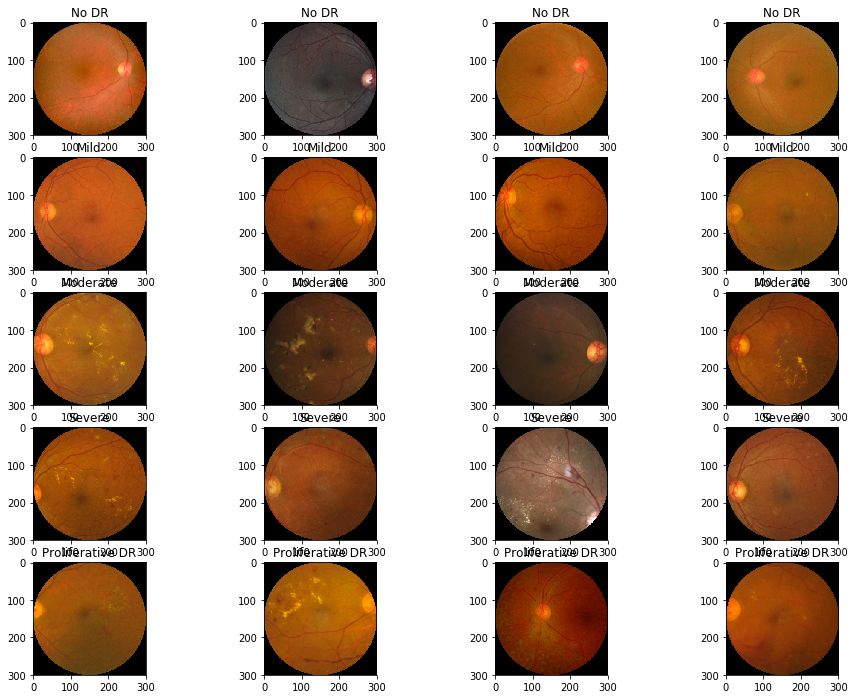

In [7]:
figure=plt.figure(figsize=(20,12))
for target_class in (df_train19['diagnosis'].unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train19.loc[df_train19.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)                                         # Reading image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                        # Converting BGR to RGB
        img = crop_image_from_gray(img)                                   # applying crop_image_from_gray()
        img = circle_crop(img)                                            # applying circle_crop()
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))                            # Resizing the image to a standard size.
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])

In [8]:
# Concanating image extension with the data.
df_train15.id_code=df_train15.id_code.apply(lambda x: x+".jpg")
df_train19.id_code=df_train19.id_code.apply(lambda x: x+".jpg")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")

# Converting Image label class as string
df_train15['diagnosis'] = df_train15['diagnosis'].astype('str')
df_train19['diagnosis'] = df_train19['diagnosis'].astype('str')

# Sample Display of dataframe after adding extension.
df_train19.head()

,id_code,diagnosis
0,000c1434d8d7.jpg,2
1,001639a390f0.jpg,4
2,0024cdab0c1e.jpg,1
3,002c21358ce6.jpg,0
4,005b95c28852.jpg,0


## Data Augmentation.

In [9]:
# defining ImageDataGenrator for Data Augumentation.
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    validation_split=0.20, # Fraction of images reserved for validation
                                         horizontal_flip=True, # Randomly flip inputs horizontally.
                                         vertical_flip=True, # Randomly flip inputs vertically.
                                         rotation_range=40, # Degree range for random rotations.
                                         zoom_range=0.2, # Range for random zoom
                                         shear_range=0.1, # Shear Intensity
                                        fill_mode='nearest')

#### Genrating Training and validation image for 2015 Dataset.

In [10]:
# Generating images after with image agumentation for training and validation.
train_generator15 = train_datagen.flow_from_dataframe(dataframe=df_train15,
                                                    directory=APTOS15_KAGGLE_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator15 = train_datagen.flow_from_dataframe(dataframe=df_train15,
                                                    directory=APTOS15_KAGGLE_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )

Found 28101 validated image filenames belonging to 5 classes.
Found 7025 validated image filenames belonging to 5 classes.


#### Genrating Training and validation image for 2019 Dataset.

In [11]:
# Generating images after with image agumentation for training and validation.
train_generator19 = train_datagen.flow_from_dataframe(dataframe=df_train19,
                                                    directory=APTOS19_KAGGLE_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator19 = train_datagen.flow_from_dataframe(dataframe=df_train19,
                                                    directory=APTOS19_KAGGLE_DIR,
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


## Model Architecture Design

#### Defining call backs for training analysis and optimization.

In [12]:
# Stops training once the model performance stops improving on a hold out validation dataset.
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)
# Save the model after every epoch.
checkpoint = ModelCheckpoint(SAVED_MODEL_NAME, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# Callback that streams epoch results to a csv file.
csv_logger = CSVLogger(filename=CSV_logs,
                       separator=',',
                       append=True)
callbacks_list = [checkpoint, csv_logger, reduce_lr, eraly_stop] 

#### Defining Model for training using Transfer learning.
* Resnet-50 weights are used as initial layers.
* Image dimension(300) are given as input shape to the model.
* New layers are defined for better optimization.
* Final layer is given to determine the class predicted by each node.

In [13]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))

    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet

model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

In [14]:
# Adjusting all the layers of the model to train on the dataset.
for layers in model_resnet.layers:
    layers.trainable = True

In [15]:
lr = 1e-3
optimizer =SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # defining Optimizer
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) #Compiling the model before training.

### Model Training and Evaluation

In [16]:
# Defining Traning and validating batch size for image processing of 2015 Dataset.
NUB_TRAIN_STEPS15 = train_generator15.n // train_generator15.batch_size
NUB_VALID_STEPS15 = valid_generator15.n // valid_generator15.batch_size

NUB_TRAIN_STEPS15, NUB_VALID_STEPS15

(1756, 439)

#### Pre-training model with 2015 Dataset
* Pre-training dataset using 2015 dataset which will set the weights to determine the type of dataset and boost the model to perform better.
* 2015 dataset was also the same dataset which was used to predict the severity level of the issue.
* it will update the weights of the model as per the requirment which will be used for training the final model.
* Best weights with lower val_loss is used to fine-tune the model. 

In [17]:
history = model_resnet.fit_generator(generator=train_generator15,
                                     steps_per_epoch=NUB_TRAIN_STEPS15,
                                     validation_data=valid_generator15,
                                     validation_steps=NUB_VALID_STEPS15,
                                     epochs=NUM_EPOCHS15,
                                                                 shuffle=True,  
                                     callbacks=callbacks_list,
                                     verbose=1)

Epoch 1/3
1756/1756 [==============================] - 1419s 808ms/step - loss: 0.9587 - acc: 0.6931 - val_loss: 0.7426 - val_acc: 0.7472

Epoch 00001: val_loss improved from inf to 0.74255, saving model to ../working/Resnet50_model.h5
Epoch 2/3
1756/1756 [==============================] - 1344s 765ms/step - loss: 0.7325 - acc: 0.7579 - val_loss: 0.7286 - val_acc: 0.7585

Epoch 00002: val_loss improved from 0.74255 to 0.72857, saving model to ../working/Resnet50_model.h5
Epoch 3/3
1756/1756 [==============================] - 1351s 770ms/step - loss: 0.6792 - acc: 0.7763 - val_loss: 0.6601 - val_acc: 0.7878

Epoch 00003: val_loss improved from 0.72857 to 0.66011, saving model to ../working/Resnet50_model.h5


In [18]:
model_resnet.load_weights(SAVED_MODEL_NAME)  # Load the best weight which perform well on the data.

In [19]:
# Defining Traning and validating batch size for image processing of 2019 Dataset.
NUB_TRAIN_STEPS19 = train_generator19.n // train_generator19.batch_size
NUB_VALID_STEPS19 = valid_generator19.n // valid_generator19.batch_size

NUB_TRAIN_STEPS19, NUB_VALID_STEPS19

(183, 45)

#### Fine-tuning the model with 2019 Dataset.
* The pre-trainned model was fine-tune(i.e. parameters of a model must be adjusted very precisely in order to fit with certain observations) with 2019 Dataset.
* Fine-tune model will be precisely train on the 2019 dataset which will be used to test 2019 testdata.

In [20]:
history = model_resnet.fit_generator(generator=train_generator19,
                                     steps_per_epoch=NUB_TRAIN_STEPS19,
                                     validation_data=valid_generator19,
                                     validation_steps=NUB_VALID_STEPS19,
                                     epochs=NUM_EPOCHS19,
                                                                 shuffle=True,  
                                     callbacks=callbacks_list,
                                     verbose=1)

Epoch 1/50
183/183 [==============================] - 144s 788ms/step - loss: 0.6683 - acc: 0.7592 - val_loss: 0.6171 - val_acc: 0.7722

Epoch 00001: val_loss improved from 0.66011 to 0.61708, saving model to ../working/Resnet50_model.h5
Epoch 2/50
183/183 [==============================] - 132s 721ms/step - loss: 0.5974 - acc: 0.7695 - val_loss: 0.5782 - val_acc: 0.7961

Epoch 00002: val_loss improved from 0.61708 to 0.57820, saving model to ../working/Resnet50_model.h5
Epoch 3/50
183/183 [==============================] - 131s 718ms/step - loss: 0.5537 - acc: 0.7961 - val_loss: 0.5663 - val_acc: 0.7947

Epoch 00003: val_loss improved from 0.57820 to 0.56628, saving model to ../working/Resnet50_model.h5
Epoch 4/50
183/183 [==============================] - 131s 715ms/step - loss: 0.5259 - acc: 0.8019 - val_loss: 0.5598 - val_acc: 0.7905

Epoch 00004: val_loss improved from 0.56628 to 0.55981, saving model to ../working/Resnet50_model.h5
Epoch 5/50
183/183 [============================

In [21]:
history.history.keys()  # Access Model Training History

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

### Training visualization

**Accuracy Vs Epoch curve**

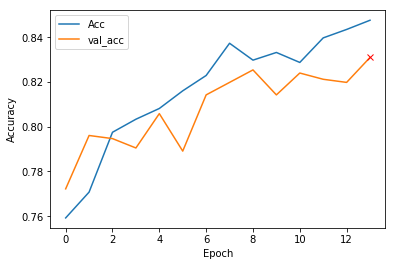

In [22]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

**log loss Vs Epoch(Learning curve)**

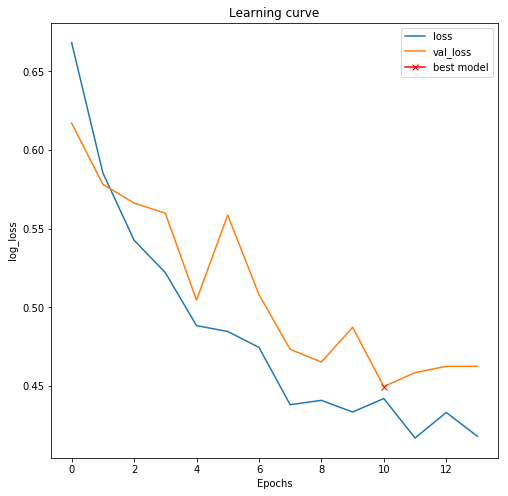

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Display the accuracy and loss obtain by the final model.**

In [24]:
(eval_loss, eval_accuracy) = tqdm(
    model_resnet.evaluate_generator(generator=valid_generator19, steps=NUB_VALID_STEPS19, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

100%|██████████| 2/2 [00:00<00:00, 7403.89it/s]

[INFO] accuracy: 81.70%
[INFO] Loss: 0.4425923616193526


In [25]:
model_resnet.load_weights(SAVED_MODEL_NAME)  # Load the best weight which perform well on the data.

### Testing Dataset

**Loading Test Dataset images for predicting label**

In [26]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = APTOS19_KAGGLE_DIR_TEST,
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=1,
                                                shuffle=False, 
                                                class_mode=None, 
                                                seed=SEED)

Found 1928 validated image filenames.


**Test Time Augmentation**

In [27]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
    preds_tta.append(preds)

100%|██████████| 10/10 [13:24<00:00, 80.35s/it]


**Predicting the labels on the test dataset**

In [28]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

**Saving the result in a dataframe with respect to the image ID**

In [29]:
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":predicted_class_indices})  
results.id_code=results.id_code.apply(lambda x: x[:-4])
results.to_csv("submission.csv", index=False)
results.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4


**Test Data Visualization**

Text(0, 0.5, 'Samples')

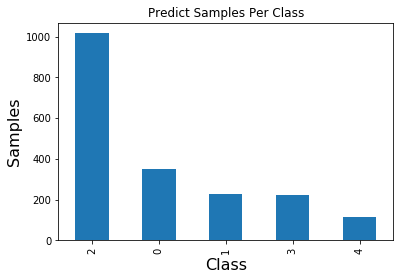

In [30]:
# Visualization of predicted test data using graphs
results['diagnosis'].value_counts().plot(kind='bar');
plt.title('Predict Samples Per Class');
plt.xlabel('Class', fontsize=16)
plt.ylabel('Samples', fontsize=16)

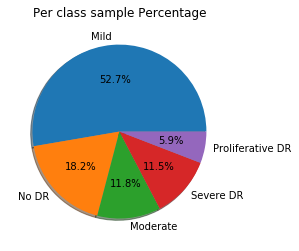

In [31]:
# Visualization of predicted test data using pie chart
plt.pie(results.diagnosis.value_counts(), autopct='%1.1f%%', shadow=True, labels=["Mild","No DR","Moderate","Severe DR", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

In [32]:
results['diagnosis'].value_counts() # Determine the no of images each class of the testing dataset.

2    1016
0     351
1     227
3     221
4     113
Name: diagnosis, dtype: int64

**Image visualization after predicting as per there class**

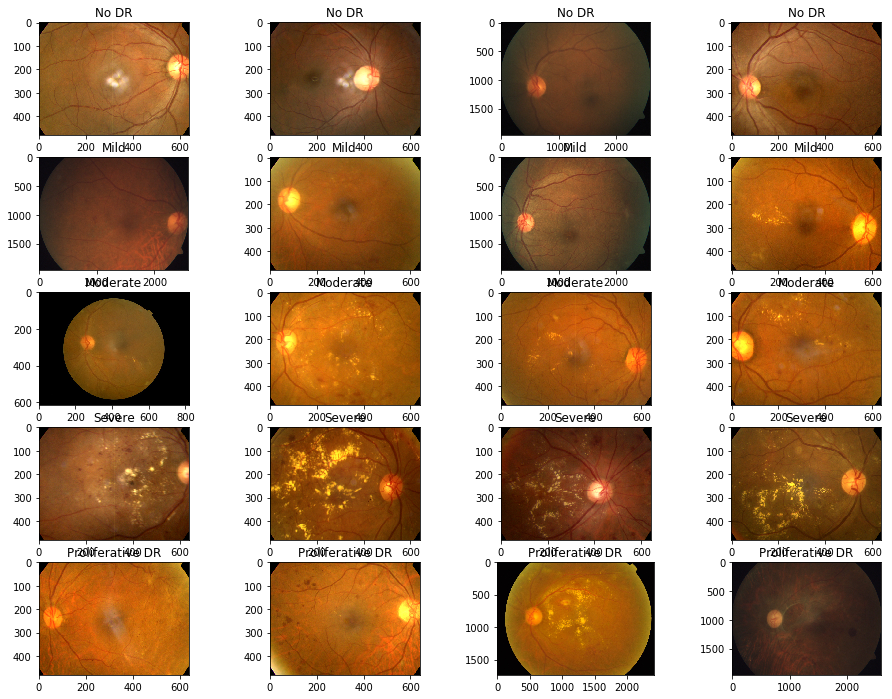

In [33]:
figure=plt.figure(figsize=(20,12))
for target_class in (results['diagnosis'].unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(results.loc[results.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/kaggle/input/aptos2019-blindness-detection/test_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])